Data Augmentation on Fashion MNIST -- Elastic Distortion

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models;
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images, test_images = train_images/255.0, test_images/255.0

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

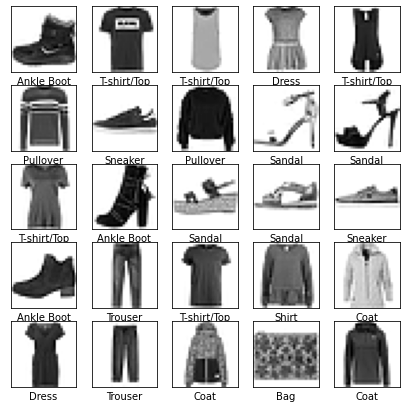

In [4]:
#verifying the data
class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

plt.figure(figsize=(7,7))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap = plt.cm.binary)
  plt.xlabel(class_names[train_labels[i]])
plt.show()

In [13]:
def elastic_transform(image, alpha_range, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       
   # Arguments
       image: Numpy array with shape (height, width, channels). 
       alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
           Controls intensity of deformation.
       sigma: Float, sigma of gaussian filter that smooths the displacement fields.
       random_state: `numpy.random.RandomState` object for generating displacement fields.
    """
    
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [16]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1);

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1);

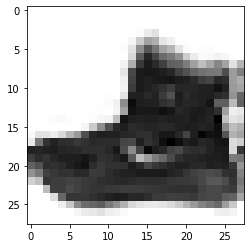

In [23]:
test_image = elastic_transform(train_images[0], 8, 3)
plt.imshow(test_image.reshape(28, 28), cmap=plt.cm.binary);

In [24]:
def elastic_augment_data(dataset, dataset_labels, augementation_factor=1):
	augmented_image = []
	augmented_image_labels = []

	for num in range (0, dataset.shape[0]):
				# original image:
				augmented_image.append(dataset[num])
				augmented_image_labels.append(dataset_labels[num])

				augmented_image.append(elastic_transform(dataset[num], 8, 3));
				augmented_image_labels.append(dataset_labels[num])

	return np.array(augmented_image), np.array(augmented_image_labels)

In [26]:
augmented_images, augmented_labels = elastic_augment_data(train_images, train_labels)

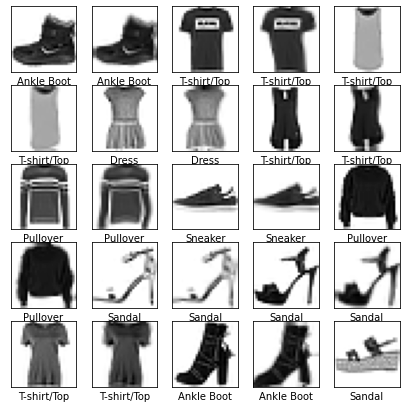

In [27]:
show_images = augmented_images.reshape(augmented_images.shape[0], 28, 28);
#verifying the data
class_names = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

plt.figure(figsize=(7,7))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(show_images[i], cmap = plt.cm.binary)
  plt.xlabel(class_names[augmented_labels[i]])
plt.show()

In [28]:
train_images.shape

(60000, 28, 28, 1)

In [29]:
augmented_images.shape

(120000, 28, 28, 1)

In [30]:
#creating the convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (5,5), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
#model.add(layers.Dense(3136, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.fit(augmented_images, augmented_labels, batch_size=128, epochs=10, verbose=1, validation_data=(train_images, train_labels))

Epoch 1/10
938/938 [==============================] - 123s 132ms/step - loss: 0.4451 - accuracy: 0.8378 - val_loss: 0.3093 - val_accuracy: 0.8863
Epoch 2/10
938/938 [==============================] - 123s 131ms/step - loss: 0.2914 - accuracy: 0.8929 - val_loss: 0.2183 - val_accuracy: 0.9207
Epoch 3/10
938/938 [==============================] - 123s 131ms/step - loss: 0.2481 - accuracy: 0.9080 - val_loss: 0.1955 - val_accuracy: 0.9272
Epoch 4/10
938/938 [==============================] - 123s 131ms/step - loss: 0.2168 - accuracy: 0.9186 - val_loss: 0.1814 - val_accuracy: 0.9324
Epoch 5/10
938/938 [==============================] - 123s 131ms/step - loss: 0.1901 - accuracy: 0.9284 - val_loss: 0.1588 - val_accuracy: 0.9411
Epoch 6/10
938/938 [==============================] - 123s 131ms/step - loss: 0.1693 - accuracy: 0.9368 - val_loss: 0.1334 - val_accuracy: 0.9514
Epoch 7/10
938/938 [==============================] - 122s 131ms/step - loss: 0.1503 - accuracy: 0.9435 - val_loss: 0.1075 -